# Robust training with MOM on PyTorch

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import numpy.random as alea
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from random import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import progressbar
import momAPI.nn.indexed_dataset as indexed_dataset
import momAPI.nn.utilities as utilities
import momAPI.nn.MOM_training as MOM_training
import momAPI.nn.MOM_sampler as MOM_sampler
import momAPI.nn.classical_nn_training as class_train
from math import log
import seaborn as sns

momAPI package
In nn __init__
In procedure __init__
In Cross_validation __init__
In Linear_models __init__


In [2]:
plt.style.use('seaborn-darkgrid')
random_seed = 7
alea.seed(random_seed)

### Test on custom model

Let $U_1,U_2$ be stochastic function, and $Y = \sigma(U_1)\sigma(2U_2)$, we want to predict Y knowing $U_1$ and $U_2$ but there are outliers in the data.

In [3]:
n_obs = 2000
n_outliers = 60

U1 = np.random.normal(0,1,n_obs)
U2 = np.random.normal(0,1,n_obs)

U1_test = np.random.normal(0,1,n_obs)
U2_test = np.random.normal(0,1,n_obs)

outliers_pos = np.random.randint(0, n_obs, n_outliers)

U_test = torch.FloatTensor(np.vstack((U1_test,U2_test)).transpose())
U = torch.FloatTensor(np.vstack((U1,U2)).transpose())

U1, U2 = torch.FloatTensor(U1), torch.FloatTensor(U2)
U1_test, U2_test = torch.FloatTensor(U1_test), torch.FloatTensor(U2_test)

Y = torch.sigmoid(U1) * torch.sigmoid(U2)
Y_test = torch.sigmoid(U1_test) * torch.sigmoid(U2_test)

for i in outliers_pos:
    Y[i] = torch.rand(1)

data_train = indexed_dataset.Dataset(U , Y)
data_test = indexed_dataset.Dataset(U_test , Y_test)

In [4]:
class nn(torch.nn.Module):
    
    #Our batch shape for input x is (3 , 64 , 64)
    
    def __init__(self):
        super(nn, self).__init__()

        self.layer = torch.nn.Linear(2, 1)
        
    def forward(self, x):
        x = torch.sigmoid(self.layer(x))
        x = x.view(-1)
        return(x)

In [15]:
nn_ = nn()
optimizer = torch.optim.SGD( nn_.parameters(), lr=1)
loss_ = torch.nn.modules.loss.MSELoss(reduce = 'mean')
MOM_nn = MOM_training.MomTraining(nn_ , optimizer , loss_ , n_epochs = 100 , batch_size = 16, n_hist = 100)
MOM_nn.fit(data_train, data_val = data_test)

nnbis_ = nn()
optimizerbis = torch.optim.SGD( nnbis_.parameters(), lr=1)
loss_ = torch.nn.modules.loss.MSELoss(reduce = 'mean')
classical_nn = class_train.ClassicalTraining(nnbis_ , optimizerbis , loss_ , n_epochs = 100 , batch_size = 16)
classical_nn.fit(data_train, data_val = data_test)

/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch n°0 (0.0sec) : loss = 0.10246596485376358, validation loss = 0.08167991042137146, accuracy = None, validation accuracy = None
Epoch n°1 (0.0sec) : loss = 0.0835329070687294, validation loss = 0.06658423691987991, accuracy = None, validation accuracy = None
Epoch n°2 (0.0sec) : loss = 0.0678805410861969, validation loss = 0.053965598344802856, accuracy = None, validation accuracy = None
Epoch n°3 (0.0sec) : loss = 0.05540144816040993, validation loss = 0.043182432651519775, accuracy = None, validation accuracy = None
Epoch n°4 (0.0sec) : loss = 0.044254641979932785, validation loss = 0.03532423824071884, accuracy = None, validation accuracy = None
Epoch n°5 (0.0sec) : loss = 0.03625849634408951, validation loss = 0.028360452502965927, accuracy = None, validation accuracy = None
Epoch n°6 (0.0sec) : loss = 0.02938903123140335, validation loss = 0.023206181824207306, accuracy = None, validation accuracy = None
Epoch n°7 (0.0sec) : loss = 0.024368125945329666, validation loss = 0.018

Epoch n°61 (0.0sec) : loss = 0.0015784123679623008, validation loss = 0.0012690878938883543, accuracy = None, validation accuracy = None
Epoch n°62 (0.0sec) : loss = 0.0015450429636985064, validation loss = 0.0012678236234933138, accuracy = None, validation accuracy = None
Epoch n°63 (0.0sec) : loss = 0.0013940301723778248, validation loss = 0.0012567117810249329, accuracy = None, validation accuracy = None
Epoch n°64 (0.0sec) : loss = 0.0017475327476859093, validation loss = 0.0012541080359369516, accuracy = None, validation accuracy = None
Epoch n°65 (0.0sec) : loss = 0.0014967134920880198, validation loss = 0.001254645292647183, accuracy = None, validation accuracy = None
Epoch n°66 (0.0sec) : loss = 0.001772595220245421, validation loss = 0.0012524869525805116, accuracy = None, validation accuracy = None
Epoch n°67 (0.0sec) : loss = 0.0015854359371587634, validation loss = 0.00125783565454185, accuracy = None, validation accuracy = None
Epoch n°68 (0.0sec) : loss = 0.00150139792822

/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch n°0 (0.0sec) : loss = 0.15908850729465485, validation loss = 0.14965960383415222, accuracy = None, validation accuracy = None
Epoch n°1 (0.0sec) : loss = 0.10507276654243469, validation loss = 0.12832869589328766, accuracy = None, validation accuracy = None
Epoch n°2 (0.0sec) : loss = 0.12144293636083603, validation loss = 0.10439703613519669, accuracy = None, validation accuracy = None
Epoch n°3 (0.0sec) : loss = 0.08054201304912567, validation loss = 0.08677321672439575, accuracy = None, validation accuracy = None
Epoch n°4 (0.0sec) : loss = 0.04778142273426056, validation loss = 0.07538345456123352, accuracy = None, validation accuracy = None
Epoch n°5 (0.0sec) : loss = 0.07129227370023727, validation loss = 0.05954744294285774, accuracy = None, validation accuracy = None
Epoch n°6 (0.0sec) : loss = 0.09063184261322021, validation loss = 0.041253793984651566, accuracy = None, validation accuracy = None
Epoch n°7 (0.0sec) : loss = 0.03743945434689522, validation loss = 0.033937

Epoch n°61 (0.0sec) : loss = 0.0008771665743552148, validation loss = 0.0014491388574242592, accuracy = None, validation accuracy = None
Epoch n°62 (0.0sec) : loss = 0.0020930198952555656, validation loss = 0.0014023138210177422, accuracy = None, validation accuracy = None
Epoch n°63 (0.0sec) : loss = 0.000661008118186146, validation loss = 0.0013918677577748895, accuracy = None, validation accuracy = None
Epoch n°64 (0.0sec) : loss = 0.0010256496025249362, validation loss = 0.0013833510456606746, accuracy = None, validation accuracy = None
Epoch n°65 (0.0sec) : loss = 0.002961481222882867, validation loss = 0.001364577910862863, accuracy = None, validation accuracy = None
Epoch n°66 (0.0sec) : loss = 0.0015445081517100334, validation loss = 0.0013677767710760236, accuracy = None, validation accuracy = None
Epoch n°67 (0.0sec) : loss = 0.001415654900483787, validation loss = 0.0013615438947454095, accuracy = None, validation accuracy = None
Epoch n°68 (0.0sec) : loss = 0.00151369138620

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


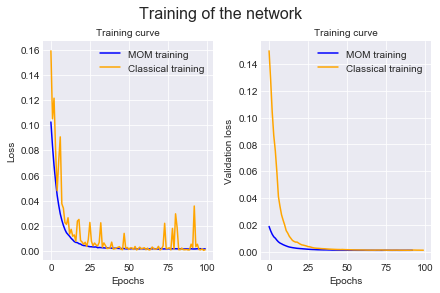

In [16]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True)
fig.suptitle("Training of the network", fontsize=16)

ax1.plot(MOM_nn.history['loss'] , color = "blue" , label = "MOM training")
ax1.plot(classical_nn.history['loss'] , color = 'orange' , label = "Classical training")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training curve", fontsize=10)

ax2.plot(MOM_nn.history['val_loss'][7:] , color = "blue" , label = "MOM training")
ax2.plot(classical_nn.history['val_loss'] , color = 'orange' , label = "Classical training")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Validation loss")
ax2.set_title("Training curve", fontsize=10)
fig.show()
plt.savefig("graphs/training_curve_bis.png")

### The database

We want to classify crocodiles and pionguins extracted from tiny-resnet. In order to check if our training is robust to outliers, we corrupt our dataset with fish photos.

#### Data importation

In [17]:
def rescale(img):
    _,_,channel = img.shape
    tab = np.zeros(img.shape)
    for i in range(channel):
        mini = np.min(img[:,:,i])
        maxi = np.max(img[:,:,i])
        tab[:,:,i] = (img[:,:,i] - mini)/(maxi-mini)
    
    return tab

def plot_torch_img(img):
    
    np_img = img.numpy()
    np_img = np.swapaxes(np_img,0,2)
    plt.imshow(np_img)

In [18]:
images = []
target = []
croc,ping = [],[]
min_n , min_p = 1000 , 1000
i = 0

for animal in ["crocodile" , "pinguin"] : 
    
    file = os.listdir("data/tiny-imagenet-200/train/" + animal + "/images")
    
    for f in file : 
        
        img = Image.open("data/tiny-imagenet-200/train/" + animal + "/images/" + f)
        n,p = img.size
        height = min(n,p)
        box = ( 0 , 0 , height , height)
        img = img.crop(box)  # On rend l'image carré en la rognant
        #img = img.resize(( 224 , 224 ))   # On standardise la taille de l'image 
        if len(np.array(img).shape) == 3 : 
            
            if animal == 'crocodile':
                croc.append(rescale(np.array(img)))
            else:
                ping.append(rescale(np.array(img)))
                
            images.append(rescale(np.array(img)))
            target.append([i])
            
    i += 1

outliers_1 = []

file = os.listdir("data/tiny-imagenet-200/train/fish/images")
    
for f in file : 
        
    img = Image.open("data/tiny-imagenet-200/train/fish/images/" + f)
    n,p = img.size
    height = min(n,p)
    box = ( 0 , 0 , height , height)
    img = img.crop(box)
    if len(np.array(img).shape) == 3 : 
            
        outliers_1.append(rescale(np.array(img)))

images_train , images_test , target_train , target_test = train_test_split(images , target ,
                                                                           random_state = random_seed)

In [19]:
hist_croc_R = []
hist_croc_G = []
hist_croc_B = []
hist_ping_R = []
hist_ping_G = []
hist_ping_B = []
hist_fish_R = []
hist_fish_G = []
hist_fish_B = []

for i in croc:
    hist_croc_R.append(np.mean(i[:,:,0]))
    hist_croc_G.append(np.mean(i[:,:,1]))
    hist_croc_B.append(np.mean(i[:,:,2]))

for i in ping:
    hist_ping_R.append(np.mean(i[:,:,0]))
    hist_ping_G.append(np.mean(i[:,:,1]))
    hist_ping_B.append(np.mean(i[:,:,2]))
    
for i in outliers_1:
    hist_fish_R.append(np.mean(i[:,:,0]))
    hist_fish_G.append(np.mean(i[:,:,1]))
    hist_fish_B.append(np.mean(i[:,:,2]))

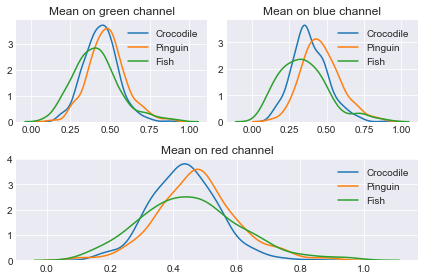

In [20]:
plt.subplot(212)
sns.distplot(hist_croc_R, bins = [i/100 for i in range(100)], hist = False, kde = True, label = "Crocodile")
sns.distplot(hist_ping_R, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Pinguin')
sns.distplot(hist_fish_R, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Fish')
plt.title('Mean on red channel')

plt.subplot(221)
sns.distplot(hist_croc_G, bins = [i/100 for i in range(100)], hist = False, kde = True, label = "Crocodile")
sns.distplot(hist_ping_G, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Pinguin')
sns.distplot(hist_fish_G, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Fish')
plt.title('Mean on green channel')

plt.subplot(222)
sns.distplot(hist_croc_B, bins = [i/100 for i in range(100)], hist = False, kde = True, label = "Crocodile")
sns.distplot(hist_ping_B, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Pinguin')
sns.distplot(hist_fish_B, bins = [i/100 for i in range(100)], hist = False, kde = True, label = 'Fish')
plt.title('Mean on blue channel')
plt.tight_layout()
plt.savefig("graphs/distribution_img.png")

#### Creation of the black and white outliers

In [21]:
n_outliers_2 = 10
outliers_2 = []
target_outliers_2 = []

for i in range(n_outliers_2):
    outliers_2.append(np.ones(images[0].shape)*randint(0,1))
    target_outliers_2.append([randint(0,1)])

#### Creation of the gaussian noise outliers

In [22]:
n_outliers_3 = 10
outliers_3 = []
target_outliers_3 = []

for i in range(n_outliers_3):
    outliers_3.append(np.random.normal(size = images[0].shape))
    target_outliers_3.append([randint(0,1)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


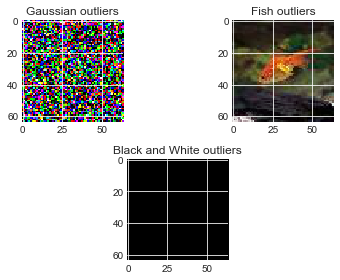

In [23]:
%matplotlib inline
plt.subplot(212)
plt.title("Black and White outliers")
plt.imshow(outliers_2[1])

plt.subplot(221)
plt.title("Gaussian outliers")
plt.imshow(outliers_3[1])

plt.subplot(222)
plt.title("Fish outliers")
plt.imshow(outliers_1[1])

plt.tight_layout()
plt.savefig("graphs/outliers.png")

#### Creation of the fish outliers and the corrupted train set

In [24]:
n_outliers_1 = 0

for i in range(n_outliers_1):
    images_train.append(outliers_1[i])
    target_train.append([randint(0,1)])
    
images_train += outliers_2
images_train += outliers_3
target_train += target_outliers_2
target_train += target_outliers_3

target_train = torch.FloatTensor(target_train)
target_test = torch.FloatTensor(target_test)

#### Data transformation

First we create a transformer in order to transform np.array to torch.tensor with the channels in the first dimension.

In [25]:
transformer = transforms.Compose( [ transforms.ToTensor() ])
data_train = indexed_dataset.Dataset(images_train , target_train , transform = transformer)
data_test = indexed_dataset.Dataset(images_test , target_test , transform = transformer)

### The network

For the architecture of my network, I used 3 convolutional layers with Relu activation, each followed by a max pooling layer, in order to extract the best feature. Then I had a dense layer with sigmoid activation in order to do 0/1 classification.

In [26]:
class CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3 , 64 , 64)
    
    def __init__(self):
        super(CNN, self).__init__()
        
        #input channels = 3, output channels = 16
        self.block_1 = torch.nn.Sequential(torch.nn.Conv2d(3 , 32 , 3 , stride = 1 , padding = 0),
                                     torch.nn.BatchNorm2d(32),
                                     torch.nn.ReLU(),
                                     torch.nn.MaxPool2d(3))
        
        #Input channels = 16, output channels = 32
        self.block_2 = torch.nn.Sequential(torch.nn.Conv2d(32 , 64 , 3 , stride = 1 , padding = 0),
                                     torch.nn.BatchNorm2d(64),
                                     torch.nn.ReLU(),
                                     torch.nn.MaxPool2d(2))
        
        #Input channels = 32, output channels = 64
        self.block_3 = torch.nn.Sequential(torch.nn.Conv2d(64 , 128 , 3 , stride = 1 , padding = 0),
                                     torch.nn.BatchNorm2d(128),
                                     torch.nn.ReLU(),
                                     torch.nn.MaxPool2d(2))
        
        #128 input features, 1 output features for binary classification
        self.fc1 = torch.nn.Linear(1152, 1)
        
        #self.conv_dropout = nn.Dropout2d(p = 0.0)
        self.dense_dropout = torch.nn.Dropout(p = 0.0)
        
    def forward(self, x):
        #print("1:", (x == x).all())
        #Computes the Fivation of the first convolution
        #Size changes from (3, 64, 64) to (32, 20, 20)
        x = self.block_1(x)
        #print(x.size())
        #print("1:", (x == x).all())
        
        #Size changes from (32, 20, 20) to (64, 9, 9)
        x = self.block_2(x)
        #print(x.size())
        #print("2:", (x == x).all())
        
        #Size changes from (64, 9, 9) to (128, 3, 3)
        x = self.block_3(x)
        #print(x.size())
        #print("3:", (x == x).all())
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (128 , 1 , 1) to (,1152)
        #Recall that the -1 infers this dimension from the other given dimension
        #print(x.size())
        x = x.view(-1,1152)
        
        #Computes the Fivation of the fully connected layer
        #Size changes from (1, 2304) to (1, 1)
        x = torch.sigmoid(self.dense_dropout(self.fc1(x)))
        
        return(x)

### Training

We use Adam optimizer and our loss is the classical binary cross entropy with a logistic loss which can be calculated with the following formula : 
$$ BCE(y,\widehat{y}) = -(ylog(\widehat{y})+(1-y)log(1-\widehat{y}))$$

In [33]:
# MOM model
CNN_ = CNN()
optimizer = torch.optim.Adam(CNN_.parameters(), lr=0.001)
loss_ = torch.nn.modules.loss.BCELoss(reduction = 'mean')
MOM_CNN = MOM_training.MomTraining(CNN_ ,optimizer ,loss_ ,n_epochs=250, batch_size=16, n_hist=200)
MOM_CNN.fit(data_train , data_val = data_test, acc = True)

# Classical model
CNN_classic = CNN()
optimizer_classic = torch.optim.Adam( CNN_classic.parameters(), lr=0.001)
loss_classic = torch.nn.modules.loss.BCELoss(reduction = 'mean')
classical_cnn = class_train.ClassicalTraining(CNN_classic, optimizer_classic, loss_classic, n_epochs=250, batch_size=16)
classical_cnn.fit(data_train, data_val = data_test, acc = True)

Epoch n°0 (5.0sec) : loss = 0.7037421464920044, validation loss = 0.6502702832221985, accuracy = 0.6649282920469362, validation accuracy = 0.6144578313253012
Epoch n°1 (4.0sec) : loss = 0.6506631374359131, validation loss = 0.6185030937194824, accuracy = 0.6949152542372882, validation accuracy = 0.6706827309236948
Epoch n°2 (5.0sec) : loss = 0.6069681644439697, validation loss = 0.5671792030334473, accuracy = 0.7444589308996089, validation accuracy = 0.7630522088353414
Epoch n°3 (4.0sec) : loss = 0.5821241140365601, validation loss = 0.5422428846359253, accuracy = 0.7679269882659713, validation accuracy = 0.7550200803212851
Epoch n°4 (3.0sec) : loss = 0.5405230522155762, validation loss = 0.5201410055160522, accuracy = 0.7770534550195567, validation accuracy = 0.7991967871485943
Epoch n°5 (4.0sec) : loss = 0.5227459669113159, validation loss = 0.5027022361755371, accuracy = 0.7640156453715776, validation accuracy = 0.7911646586345381
Epoch n°6 (5.0sec) : loss = 0.5294185280799866, vali

Epoch n°52 (5.0sec) : loss = 0.2618015706539154, validation loss = 0.2785262167453766, accuracy = 0.9061277705345502, validation accuracy = 0.8875502008032129
Epoch n°53 (5.0sec) : loss = 0.27291250228881836, validation loss = 0.283703088760376, accuracy = 0.9009126466753585, validation accuracy = 0.8995983935742972
Epoch n°54 (4.0sec) : loss = 0.2626956105232239, validation loss = 0.2908759117126465, accuracy = 0.8996088657105606, validation accuracy = 0.8875502008032129
Epoch n°55 (5.0sec) : loss = 0.26933223009109497, validation loss = 0.2989124655723572, accuracy = 0.8996088657105606, validation accuracy = 0.8835341365461847
Epoch n°56 (3.0sec) : loss = 0.2639407515525818, validation loss = 0.30859318375587463, accuracy = 0.8891786179921773, validation accuracy = 0.8875502008032129
Epoch n°57 (3.0sec) : loss = 0.33220982551574707, validation loss = 0.31183746457099915, accuracy = 0.8878748370273793, validation accuracy = 0.8835341365461847
Epoch n°58 (4.0sec) : loss = 0.27400016784

Epoch n°104 (5.0sec) : loss = 0.2009185254573822, validation loss = 0.23423059284687042, accuracy = 0.9295958279009127, validation accuracy = 0.8955823293172691
Epoch n°105 (4.0sec) : loss = 0.1989799290895462, validation loss = 0.21651512384414673, accuracy = 0.940026075619296, validation accuracy = 0.9156626506024096
Epoch n°106 (4.0sec) : loss = 0.18122388422489166, validation loss = 0.2067478597164154, accuracy = 0.940026075619296, validation accuracy = 0.9236947791164659
Epoch n°107 (5.0sec) : loss = 0.18732668459415436, validation loss = 0.20245686173439026, accuracy = 0.9387222946544981, validation accuracy = 0.9317269076305221
Epoch n°108 (5.0sec) : loss = 0.17435652017593384, validation loss = 0.20532727241516113, accuracy = 0.9335071707953064, validation accuracy = 0.9317269076305221
Epoch n°109 (4.0sec) : loss = 0.2116987258195877, validation loss = 0.21705998480319977, accuracy = 0.924380704041721, validation accuracy = 0.9196787148594378
Epoch n°110 (4.0sec) : loss = 0.211

Epoch n°155 (5.0sec) : loss = 0.17533619701862335, validation loss = 0.25106722116470337, accuracy = 0.9387222946544981, validation accuracy = 0.9236947791164659
Epoch n°156 (4.0sec) : loss = 0.16470685601234436, validation loss = 0.24287177622318268, accuracy = 0.940026075619296, validation accuracy = 0.9196787148594378
Epoch n°157 (4.0sec) : loss = 0.16152779757976532, validation loss = 0.23280426859855652, accuracy = 0.9465449804432855, validation accuracy = 0.9196787148594378
Epoch n°158 (4.0sec) : loss = 0.15644173324108124, validation loss = 0.22402936220169067, accuracy = 0.9465449804432855, validation accuracy = 0.927710843373494
Epoch n°159 (5.0sec) : loss = 0.15110474824905396, validation loss = 0.21657612919807434, accuracy = 0.954367666232073, validation accuracy = 0.9317269076305221
Epoch n°160 (4.0sec) : loss = 0.1265130639076233, validation loss = 0.21153998374938965, accuracy = 0.9530638852672751, validation accuracy = 0.9317269076305221
Epoch n°161 (3.0sec) : loss = 0.

Epoch n°206 (5.0sec) : loss = 0.16952458024024963, validation loss = 0.2573263347148895, accuracy = 0.9426336375488917, validation accuracy = 0.9196787148594378
Epoch n°207 (5.0sec) : loss = 0.14420606195926666, validation loss = 0.2740679681301117, accuracy = 0.9426336375488917, validation accuracy = 0.9156626506024096
Epoch n°208 (4.0sec) : loss = 0.19272680580615997, validation loss = 0.28859806060791016, accuracy = 0.9426336375488917, validation accuracy = 0.8995983935742972
Epoch n°209 (3.0sec) : loss = 0.13830871880054474, validation loss = 0.30091455578804016, accuracy = 0.9413298565840938, validation accuracy = 0.8955823293172691
Epoch n°210 (5.0sec) : loss = 0.18311165273189545, validation loss = 0.30026543140411377, accuracy = 0.9413298565840938, validation accuracy = 0.8955823293172691
Epoch n°211 (5.0sec) : loss = 0.17955565452575684, validation loss = 0.2909988760948181, accuracy = 0.9478487614080835, validation accuracy = 0.8995983935742972
Epoch n°212 (5.0sec) : loss = 0

Epoch n°7 (5.0sec) : loss = 0.6557396054267883, validation loss = 0.41489142179489136, accuracy = 0.7301173402868318, validation accuracy = 0.8393574297188755
Epoch n°8 (4.0sec) : loss = 0.40431106090545654, validation loss = 0.400459885597229, accuracy = 0.7940026075619296, validation accuracy = 0.8594377510040161
Epoch n°9 (2.0sec) : loss = 0.6326448917388916, validation loss = 0.3942704498767853, accuracy = 0.8318122555410691, validation accuracy = 0.8433734939759037
Epoch n°10 (2.0sec) : loss = 0.40752866864204407, validation loss = 0.3906409740447998, accuracy = 0.8500651890482399, validation accuracy = 0.8433734939759037
Epoch n°11 (2.0sec) : loss = 0.5826113224029541, validation loss = 0.38864806294441223, accuracy = 0.8696219035202086, validation accuracy = 0.8393574297188755
Epoch n°12 (2.0sec) : loss = 0.28053611516952515, validation loss = 0.38744446635246277, accuracy = 0.8800521512385919, validation accuracy = 0.8473895582329317
Epoch n°13 (2.0sec) : loss = 0.2786016166210

Epoch n°59 (2.0sec) : loss = 0.7889645099639893, validation loss = 0.3122817575931549, accuracy = 0.8904823989569752, validation accuracy = 0.8634538152610441
Epoch n°60 (2.0sec) : loss = 0.10130031406879425, validation loss = 0.30323174595832825, accuracy = 0.9009126466753585, validation accuracy = 0.8674698795180723
Epoch n°61 (2.0sec) : loss = 0.16356950998306274, validation loss = 0.2886756658554077, accuracy = 0.9061277705345502, validation accuracy = 0.8755020080321285
Epoch n°62 (2.0sec) : loss = 0.25576251745224, validation loss = 0.28802555799484253, accuracy = 0.9022164276401564, validation accuracy = 0.8755020080321285
Epoch n°63 (2.0sec) : loss = 0.19905546307563782, validation loss = 0.28800761699676514, accuracy = 0.9048239895697523, validation accuracy = 0.8714859437751004
Epoch n°64 (3.0sec) : loss = 0.17112863063812256, validation loss = 0.28756654262542725, accuracy = 0.9048239895697523, validation accuracy = 0.8755020080321285
Epoch n°65 (4.0sec) : loss = 0.548986613

Epoch n°111 (3.0sec) : loss = 0.24571405351161957, validation loss = 0.20841681957244873, accuracy = 0.940026075619296, validation accuracy = 0.9236947791164659
Epoch n°112 (3.0sec) : loss = 0.09919503331184387, validation loss = 0.21195563673973083, accuracy = 0.9322033898305084, validation accuracy = 0.9236947791164659
Epoch n°113 (3.0sec) : loss = 0.2887941002845764, validation loss = 0.21575528383255005, accuracy = 0.9269882659713168, validation accuracy = 0.9196787148594378
Epoch n°114 (3.0sec) : loss = 0.405418336391449, validation loss = 0.21606296300888062, accuracy = 0.9465449804432855, validation accuracy = 0.9196787148594378
Epoch n°115 (3.0sec) : loss = 0.3509069085121155, validation loss = 0.21776682138442993, accuracy = 0.9426336375488917, validation accuracy = 0.9156626506024096
Epoch n°116 (2.0sec) : loss = 0.3231891393661499, validation loss = 0.2216009795665741, accuracy = 0.9491525423728814, validation accuracy = 0.9236947791164659
Epoch n°117 (3.0sec) : loss = 0.242

Epoch n°162 (3.0sec) : loss = 0.14217738807201385, validation loss = 0.2404145449399948, accuracy = 0.9374185136897001, validation accuracy = 0.9317269076305221
Epoch n°163 (3.0sec) : loss = 0.05582670494914055, validation loss = 0.2340061515569687, accuracy = 0.9348109517601043, validation accuracy = 0.9317269076305221
Epoch n°164 (3.0sec) : loss = 0.22181616723537445, validation loss = 0.23216360807418823, accuracy = 0.9295958279009127, validation accuracy = 0.927710843373494
Epoch n°165 (3.0sec) : loss = 0.08180078864097595, validation loss = 0.23515044152736664, accuracy = 0.9308996088657105, validation accuracy = 0.9236947791164659
Epoch n°166 (3.0sec) : loss = 0.13853850960731506, validation loss = 0.23728278279304504, accuracy = 0.9269882659713168, validation accuracy = 0.9156626506024096
Epoch n°167 (3.0sec) : loss = 0.21285171806812286, validation loss = 0.24153894186019897, accuracy = 0.9230769230769231, validation accuracy = 0.9116465863453815
Epoch n°168 (2.0sec) : loss = 0

Epoch n°213 (3.0sec) : loss = 0.3001641035079956, validation loss = 0.22058507800102234, accuracy = 0.954367666232073, validation accuracy = 0.9397590361445783
Epoch n°214 (3.0sec) : loss = 0.03363405913114548, validation loss = 0.22112980484962463, accuracy = 0.9569752281616688, validation accuracy = 0.9397590361445783
Epoch n°215 (3.0sec) : loss = 0.1069280132651329, validation loss = 0.22581952810287476, accuracy = 0.9556714471968709, validation accuracy = 0.9317269076305221
Epoch n°216 (3.0sec) : loss = 0.04831099137663841, validation loss = 0.23049010336399078, accuracy = 0.9491525423728814, validation accuracy = 0.927710843373494
Epoch n°217 (2.0sec) : loss = 0.1010882705450058, validation loss = 0.23697875440120697, accuracy = 0.9478487614080835, validation accuracy = 0.9156626506024096
Epoch n°218 (2.0sec) : loss = 0.10435765236616135, validation loss = 0.24393928050994873, accuracy = 0.9426336375488917, validation accuracy = 0.9116465863453815
Epoch n°219 (2.0sec) : loss = 0.0

### Analysis

In [34]:
history = MOM_CNN.history
history_class = classical_cnn.history
model_MOM = MOM_CNN.model
model_classic = classical_cnn.model

#### Training curves

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


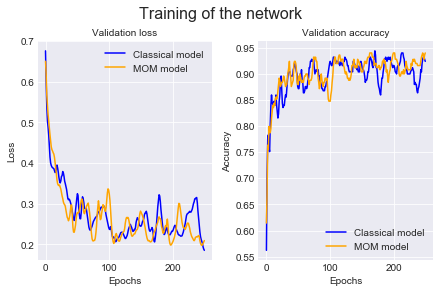

In [35]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True)
fig.suptitle("Training of the network", fontsize=16)

ax1.plot(history_class['val_loss'] , color = "blue" , label = "Classical model")
ax1.plot(history['val_loss'] , color = 'orange' , label = "MOM model")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Validation loss", fontsize=10)

ax2.plot(history_class['val_acc'] , color = "blue" , label = "Classical model")
ax2.plot(history['val_acc'] , color = 'orange' , label = "MOM model")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Validation accuracy", fontsize=10)
fig.show()
plt.savefig("graphs/training_curve.png")

#### Outliers detection

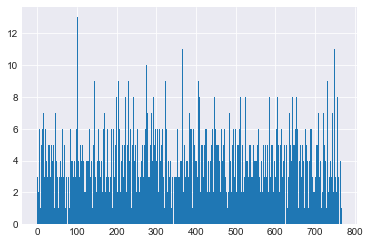

In [36]:
non_outliers = np.unique(MOM_CNN.history['hist'])
freq = plt.hist(MOM_CNN.history['hist'] , bins = np.arange(len(data_train)+1))[0]

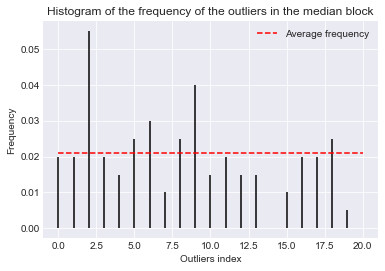

In [37]:
plt.vlines(np.arange(20), ymin = np.zeros(20), ymax = freq[-20:]/200)
plt.hlines(4.17209908/200, xmin = 0, xmax = 20, color = 'red', linestyle = '--', label = "Average frequency")
plt.xlabel("Outliers index")
plt.ylabel("Frequency")
plt.title("Histogram of the frequency of the outliers in the median block")
plt.legend()
plt.savefig("graphs/hist_out.png")

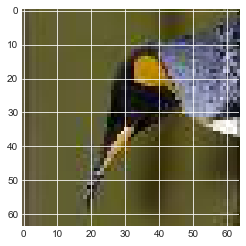

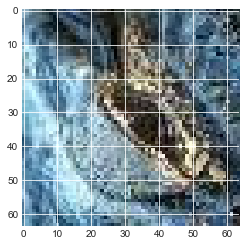

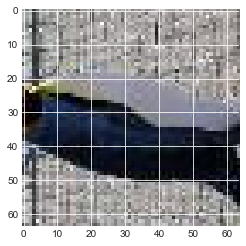

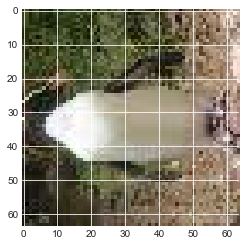

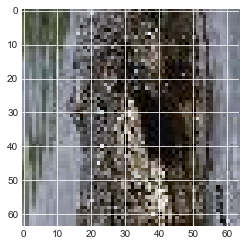

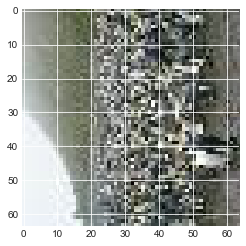

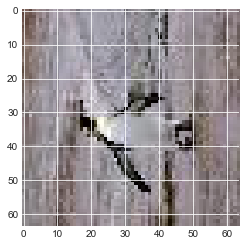

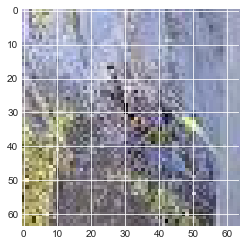

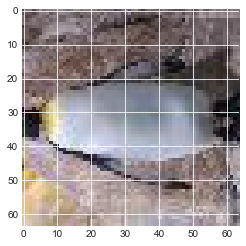

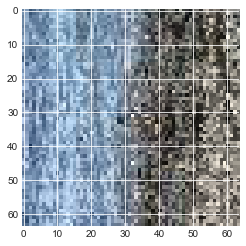

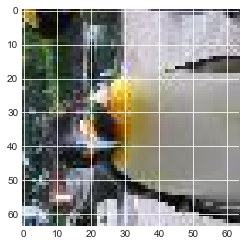

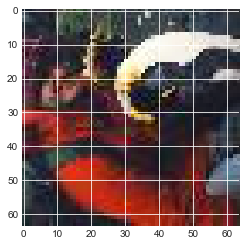

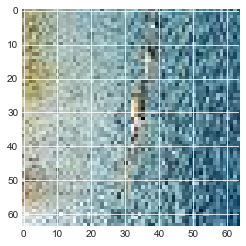

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


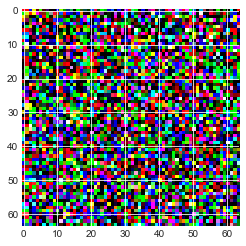

In [38]:
outliers = []
for i in range(len(data_train)):
    if i not in non_outliers:
        outliers.append(i)
        
for i,x in enumerate(outliers):
    plot_torch_img(data_train[x][0])
    plt.show()

### Test

In [40]:
#model = CNN()
#model.load_state_dict(torch.load("models/CNN_1"))

X = torch.stack([data_train[i][0] for i in range(len(data_train))]).float()
Y = torch.stack([data_train[i][1] for i in range(len(data_train))]).float().detach().numpy().flatten()
pred = model_MOM(X).detach().numpy().flatten()
pred[pred>0.5] = 1
pred[pred<=0.5] = 0
print("Accuracy on the test set :",1-np.sum(np.abs(pred-Y))/len(Y))

Accuracy on the test set : 0.9595827900912647


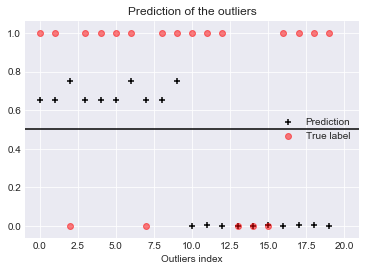

In [42]:
plt.scatter(np.arange(20), model_MOM(X).detach().numpy().flatten()[-20:], color = "black", marker = "+", label = 'Prediction')
plt.scatter(np.arange(20), Y[-20:], color = "red", alpha = 0.5, label = "True label")
plt.hlines(0.5, xmin = -1, xmax = 21)
plt.xlim(-1,21)
plt.xlabel("Outliers index")
plt.title("Prediction of the outliers")
plt.legend()
plt.savefig("graphs/pred_out.png")

### Test of the robustness

In [43]:
images = []
target = []
min_n , min_p = 1000 , 1000
i = 0

for animal in ["crocodile" , "pinguin"] : 
    
    file = os.listdir("data/tiny-imagenet-200/train/" + animal + "/images")
    
    for f in file : 
        
        img = Image.open("data/tiny-imagenet-200/train/" + animal + "/images/" + f)
        n,p = img.size
        height = min(n,p)
        box = ( 0 , 0 , height , height)
        img = img.crop(box)  # On rend l'image carré en la rognant
        #img = img.resize(( 224 , 224 ))   # On standardise la taille de l'image 
        if len(np.array(img).shape) == 3 : 
            
            images.append(np.array(img)/255)
            target.append(i)
            
    i += 1

outliers = []

file = os.listdir("data/tiny-imagenet-200/train/fish/images")
    
for f in file : 
        
    img = Image.open("data/tiny-imagenet-200/train/fish/images/" + f)
    n,p = img.size
    height = min(n,p)
    box = ( 0 , 0 , height , height)
    img = img.crop(box)
    if len(np.array(img).shape) == 3 : 
            
        outliers.append(np.array(img)/255)
        
images_train , images_test , target_train , target_test = train_test_split(images , target , random_state = random_seed)

In [ ]:
data_test = indexed_dataset.Dataset(images_test , torch.FloatTensor(target_test).view(-1,1) , transform = transformer)
history_MOM = []
history_class = []
outliers_2 = []
target_outliers_2 = []
bar = progressbar.progressbar

for i in range(200):
    outliers_2.append(rescale(np.random.normal(0, 1, images[i].shape)))
    target_outliers_2.append(randint(0,1))
    
for n_outliers in bar(range(1, 101, 10)):
    
    images_train_prime = images_train + outliers_2[:n_outliers]
    target_train_prime = target_train + target_outliers_2[:n_outliers]
    data_train = indexed_dataset.Dataset(images_train_prime , torch.FloatTensor(target_train_prime).view(-1,1) , transform = transformer)

    model_MOM = CNN()
    optimizer_MOM = torch.optim.Adam(model_MOM.parameters(), lr = 0.001)
    loss_MOM = torch.nn.modules.loss.BCEWithLogitsLoss(reduction = 'mean')
    MOM_CNN = MOM_training.mom_net(model_MOM, optimizer_MOM,
                                   loss_MOM, random_seed = random_seed,
                                   batch_size = 16, n_epochs = 250, n_hist = 0)
    MOM_CNN.fit(data_train, data_val = data_test, acc = True)
    

    model_classic = CNN()
    optimizer_classic = torch.optim.Adam( model_classic.parameters(), lr=0.001)
    loss_classic = torch.nn.modules.loss.BCEWithLogitsLoss(reduction = 'mean')
    classical_cnn = class_train.mom_net(model_classic , optimizer_classic,
                                        loss_classic, random_seed = random_seed,
                                        n_epochs = 100 , batch_size = 16, n_hist = 0)
    classical_cnn.fit(data_train, data_val = data_test, acc = True)

    
    history_MOM.append(MOM_CNN.history)
    history_class.append(classical_cnn.history)

In [22]:
MOM_dict = {}
class_dict = {}
for i in range(10):
    MOM_dict[i] = history_MOM[i]
    class_dict[i] = history_class[i]

In [23]:
import pickle
pickle.dump(MOM_dict, open( "momdico.p", "wb" ) )
pickle.dump(class_dict, open( "classdico.p", "wb" ) )

In [49]:
MOM_acc = []
MOM_loss = []
MOM_acc_bis = []
class_acc = []
class_loss = []
class_acc_bis = []

for i in range(10):
    MOM_acc.append(max(MOM_dict[i]['val_acc']))
    class_acc.append(max(class_dict[i]['val_acc']))
    MOM_loss.append(max(MOM_dict[i]['val_loss']))
    class_loss.append(max(class_dict[i]['val_loss']))
    MOM_acc_bis.append(MOM_dict[i]['val_acc'][-1])
    class_acc_bis.append(class_dict[i]['val_acc'][-1])

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


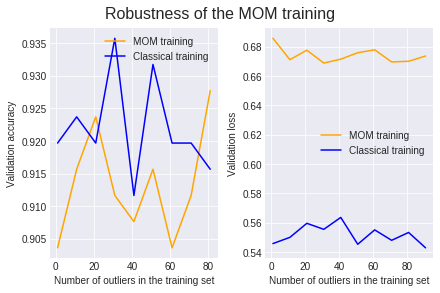

In [48]:
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True)
fig.suptitle("Robustness of the MOM training", fontsize=16)

ax1.plot(list(range(1,91,10)), MOM_acc[:-1], color = 'orange', label = "MOM training")
ax1.plot(list(range(1,91,10)), class_acc[:-1], color = 'blue', label = "Classical training")
ax1.set_xlabel("Number of outliers in the training set")
ax1.set_ylabel("Validation accuracy")
ax1.legend()


ax2.plot(list(range(1,101,10)), MOM_loss, color = 'orange', label = "MOM training")
ax2.plot(list(range(1,101,10)), class_loss, color = 'blue', label = "Classical training")
ax2.set_xlabel("Number of outliers in the training set")
ax2.set_ylabel("Validation loss")
ax2.legend()

fig.show()
plt.savefig("robustness_deep.png")

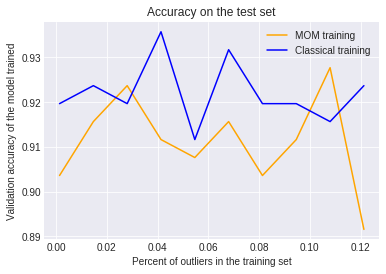

In [63]:
plt.plot(np.array(range(1,101,10))/750, MOM_acc, color = 'orange', label = "MOM training")
plt.plot(np.array(range(1,101,10))/750, class_acc, color = 'blue', label = "Classical training")
plt.xlabel("Percent of outliers in the training set")
plt.ylabel("Validation accuracy of the model trained")
plt.legend()
plt.title("Accuracy on the test set")
plt.savefig("robust_deep_2.png")